In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, cross_validate, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

In [3]:
# get features
datapath = r"C:\Users\Alvin\Desktop\UT\fall2019\research project\dep final proj\CBT_LLLT_features.csv"
df = pd.read_csv(datapath)

# get labels
labelpath = r"C:\Users\Alvin\Desktop\UT\fall2019\research project\dep final proj\dep_QIDS.csv"
df_label = pd.read_csv(labelpath)

In [4]:
# get percent improvement at week 8 and classified into two groups using 0.5 improvement as boundary 
# 1 means significant improvement, and 0 means insignificant improvement

df_label = df_label[df_label.Available.isna()==False]
df_label["improve_ratio"] = (df_label["QIDS at BL"] - df_label["QIDS week 8"])/df_label["QIDS at BL"]
df_label = df_label.reset_index(drop=True)
df_label["improve_0.5"] = "na"
for i in range(0, len(df_label.improve_ratio)):
    if df_label.improve_ratio[i] < 0.5:
         df_label["improve_0.5"][i] = 0
    else:
        df_label["improve_0.5"][i] = 1
df_label["improve_0.5"] = df_label["improve_0.5"].astype('int32')
df_label

C:\Users\Alvin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Alvin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Record ID,QIDS at BL,QIDS week 8,Available,resid_wk4,resid_wk8,resid_wk12,improve_ratio,improve_0.5
0,217,17,7.0,1.0,-6.886655,-2.629953,2.863476,0.588235,1
1,287,19,13.0,1.0,1.001742,1.810611,NaN,0.315789,0
2,464,16,14.0,1.0,5.669147,5.149765,11.483375,0.125000,0
3,518,20,14.0,1.0,1.445941,2.030893,5.003778,0.300000,0
4,591,16,10.0,1.0,2.669147,1.149765,NaN,0.375000,0
5,751,16,3.0,1.0,-4.330853,-5.850235,-5.516625,0.812500,1
6,911,18,6.0,1.0,-0.442456,-4.409671,-3.756423,0.666667,1
7,924,18,6.0,1.0,-6.442456,-4.409671,-6.756423,0.666667,1
8,942,10,2.0,1.0,-1.996044,-2.171927,-2.797229,0.800000,1
9,1055,18,14.0,1.0,-0.442456,3.590329,NaN,0.222222,0


In [5]:
# merge features and labels, for following prediction, improve_0.5 is used as label (change to whatever label you want to use in future)

df_label1 = df_label[["Record ID", "improve_0.5"]]
df=pd.merge(df, df_label1, left_on="Record Id", right_on="Record ID")
df.drop("Record ID", axis=1, inplace=True)
df

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,mel_freq5_delta,mel_freq6_delta,mel_freq7_delta,mel_freq8_delta,pitch_delta,magnitude_delta,chroma_ener_avg_delta,zero_cross_rate_delta,Record Id,improve_0.5
0,-239.513574,41.694798,-82.011085,4.159306,-12.262586,13.796800,-20.637196,-11.622997,-10.768946,-0.292671,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1055,0
1,-222.830583,44.980201,-88.716640,6.502889,-13.369073,11.668922,-14.730706,-2.892193,-12.370176,-3.898755,...,2.450231,2.375752,0.265836,0.417316,-2.965858,0.001603,0.0,0.092285,1055,0
2,-225.960080,44.627084,-86.704187,13.712355,-11.861403,12.516545,-16.499868,-4.538289,-5.684513,-1.809459,...,0.774059,-0.152957,0.950297,-0.926956,9.925484,0.007144,0.0,0.006836,1055,0
3,-231.875804,39.466115,-90.979345,11.988355,-10.363558,11.358681,-18.076440,-7.534345,-11.069544,-5.553638,...,-0.730104,-0.416340,-0.288132,-0.294116,6.850777,-0.000061,0.0,-0.012207,1055,0
4,-227.746126,45.558285,-80.698413,4.879035,-6.688264,13.411695,-20.171685,-9.879432,-11.794359,1.723916,...,-1.442556,-1.583658,-1.096247,1.376421,-3.608429,-0.005250,0.0,-0.003906,1055,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155018,-372.276641,47.548032,-30.203254,-25.752518,-16.700279,-10.932835,-2.112484,9.207634,-3.155421,-1.011040,...,-4.275318,1.563752,0.526786,2.031052,0.300339,-0.007094,0.0,0.072754,942,1
155019,-388.398529,31.397903,-18.074681,-1.713849,4.097436,2.533372,-1.639686,7.187384,0.759382,2.823090,...,-3.299556,0.053653,0.731613,1.149718,18.158752,-0.002491,0.0,0.062988,942,1
155020,-385.396880,32.815732,-22.384682,-2.983271,5.517545,-0.660358,-10.002551,-0.875990,-3.691017,4.477122,...,0.596227,0.219163,-0.156057,-0.466582,0.840759,0.000218,0.0,-0.013672,942,1
155021,-372.955878,28.373612,-18.130649,10.565806,8.053597,15.701506,-6.494263,-2.287263,-2.120863,-7.124207,...,1.212428,1.812421,4.998411,1.263253,-16.037369,0.000175,0.0,0.022949,942,1


In [6]:
# inspect if label balanced
label_count = df.groupby("improve_0.5").size()
label_count

improve_0.5
0    90037
1    64986
dtype: int64

In [7]:
# benchmark accuracy

ben_accuracy = np.max(label_count)/sum(label_count)
ben_accuracy

0.5807976880849939

In [8]:
x = df[df.columns[df.columns!="improve_0.5"] & df.columns[df.columns!="Record Id"]].values
y = df["improve_0.5"].values
print(x.shape)
print(y.shape)

(155023, 50)
(155023,)


In [11]:
# scaling or standardization data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# scaler = MinMaxScaler()
std = StandardScaler()
x_sca = std.fit_transform(x)

In [10]:
# grid search with cv to find best hyperparameter, logistic regression model
# ridge regularization used

param_grid = {'C': [0.1, 1, 5, 10]}
scoring = ('roc_auc', 'accuracy', 'precision', 'recall', 'f1')
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

lr_clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500, random_state=0)
grid_search = GridSearchCV(lr_clf, param_grid, cv=skf, return_train_score=True,
                          scoring=scoring, refit='roc_auc')

grid_search.fit(x_sca, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={'C': [0.1, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=True,
             scoring=('roc_auc', 'accuracy', 'precision', 'recall', 'f1'),
             verbose=0)

In [11]:
gs_results = pd.DataFrame({'params': grid_search.cv_results_["params"],
                                'avg_test_accuracy': grid_search.cv_results_["mean_test_accuracy"], 
                           'avg_test_roc_auc': grid_search.cv_results_["mean_test_roc_auc"],
                           'avg_test_f1': grid_search.cv_results_["mean_test_f1"]}).set_index('params')

gs_results

,avg_test_accuracy,avg_test_roc_auc,avg_test_f1
params,,,
{'C': 0.1},0.741574,0.804097,0.674122
{'C': 1},0.740684,0.804168,0.673546
{'C': 5},0.740516,0.804173,0.673404
{'C': 10},0.740497,0.804172,0.673392


In [12]:
# use accuracy as criteria, then best C=0.1. If use auc as criteria, then best C=5
# use C=0.1 and 10-fold cv to cross validate final logistic regression model, with feature selection

C=0.1
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

clf = LogisticRegression(C=C, penalty='l2', solver='lbfgs', max_iter=500, random_state=0)
lr_cv = cross_validate(clf, x_sca, y, cv=skf, scoring=('roc_auc','accuracy','precision','recall','f1'), 
               return_estimator=True, return_train_score=True)
lr_pred_proba = cross_val_predict(clf, x_sca, y, cv=skf, method="predict_proba")

In [56]:
# get model level metrics 

def model_performance_metrics(y, pred, threshold):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_cv = [roc_auc_score(y, pred),
                    accuracy_score(y, pred>threshold),
                    precision_score(y, pred>threshold),
                    recall_score(y, pred>threshold),
                    f1_score(y, pred>threshold)]

    all_metrics = pd.DataFrame({'Metrics':metric_names,
                                '10-fold CV Test Scores':metric_values_cv}).set_index('Metrics')
    print(all_metrics)

In [57]:
# plot model roc curve

def plot_roc_curve(y, pred, fig_name):
    roc_auc_test = roc_auc_score(y, pred)
    fpr_test, tpr_test, _ = roc_curve(y, pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    try:
        plt.savefig(fig_name + '.jpeg')
    except:
        pass
    plt.show()

In [58]:
# get feature importance
# handle either cross validation (cross_validate) or individual model fitter  

def coef_importance(selected_col, clf_cv, threshold, fig_name):
    try:
        coef = clf_cv["estimator"][0].coef_
        for i in range(1, len(clf_cv["estimator"])):
            coef = coef + clf_cv["estimator"][i].coef_
        coef = coef/len(clf_cv["estimator"])
    except:
        coef = clf_cv.coef_
    
    sel_coef = pd.DataFrame(list(zip(selected_col, coef.flatten()))).sort_values(by=[1], ascending=False)
    sel_coef.columns = ['feature', 'coef']
    sel_coef = sel_coef.reset_index(drop=True)
    # computes the ratio of coefficient value to maximum absolute coefficient value, and compare to threshold
    for i in range(0, len(sel_coef)):
        if (sel_coef.coef[i] >0 and (sel_coef.coef[i]/np.max(sel_coef.coef))<threshold) or (sel_coef.coef[i] 
                                                          <0 and (sel_coef.coef[i]/np.min(sel_coef.coef))<threshold):
            sel_coef.drop(i, inplace=True)
    
    sel_coef = sel_coef.reset_index(drop=True)
    x = sel_coef.values
    
    ax = sel_coef.plot.barh(figsize=(x.shape[0]/5,x.shape[0]/3))
    t = np.arange(x.shape[0])
    ax.set_yticks(t)
    ax.set_yticklabels(sel_coef['feature'])
    plt.title('Feature Importance')
    plt.show()
    
    sel_feat = list(sel_coef.feature)
    print("Percent number of features selected:", len(sel_feat)/len(selected_col)*100, "%")
    
    try:
        ax.get_figure().savefig(fig_name + '.jpeg', bbox_inches='tight')
    except:
        pass
        
    return sel_feat

In [59]:
# get individual level prediction results

def get_pred_results(df, df_label, pred_proba, threshold):
    
    df_copy = df
    df_copy["pred_proba"] = pred_proba[:,1]
    avg_proba = []

    for i in df_copy["Record Id"].unique():
        avg_proba.append(df_copy[df_copy["Record Id"] == i].pred_proba.sum()/len(df_copy[df_copy["Record Id"] == i]))

    df_final = pd.DataFrame(list(zip(df_copy["Record Id"].unique(), avg_proba)), columns = ["Record Id", "avg_proba"])
    df_final["pred_0.5"] = 0

    for i in range(0, len(df_final)):
        if df_final.avg_proba[i] > avg_proba_threshold:
            df_final["pred_0.5"][i] = 1
        else:
            df_final["pred_0.5"][i] = 0

    # merge with label
    df_final = df_final.merge(df_label[["Record ID","improve_ratio","improve_0.5"]], left_on="Record Id", right_on="Record ID")
    df_final.drop("Record ID", axis=1, inplace=True)
    df_final
    
    return df_final

In [60]:
# get confusion matrix plot
# can handle either model level or individual level confusion matrix plot
# for probability as y_pred, set a threshold as decision boundary for 1 and 0. For integer y_pred, set threshold as None

def plot_confusion_matrix(y_true, y_pred, threshold, fig_name):
    
    cmap=plt.cm.Blues
    pred=[]
    
    if threshold is not None:
        for i in y_pred:
            if i <= threshold:
                pred.append(0)
            else:
                pred.append(1)
        y_pred=np.array(pred)
    
    classes = np.array(["insignificant improve", "significant improve"])
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '2d'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="bottom",
                    color="red", fontsize=12)
    fig.tight_layout()
    try:
        fig.savefig(fig_name + '.jpeg', bbox_inches='tight')
    except:
        pass
    
    plt.show

In [18]:
# choose a probability threshold to determine how high a probability will be judged as 1, otherwise 0 
# get model performance metrics

proba_threshold = 0.5
model_performance_metrics(y, lr_pred_proba[:,1], proba_threshold)

           10-fold CV Test Scores
Metrics                          
AUC                      0.804089
Accuracy                 0.741574
Precision                0.715033
Recall                   0.637660
f1-score                 0.674134


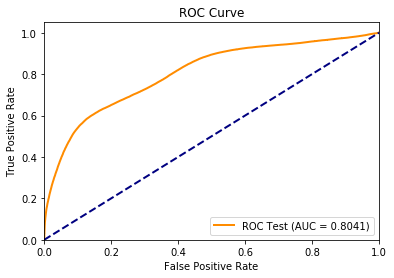

In [19]:
# plot roc curve, if you want to save the figure, just give it a name, otherwise input None

plot_roc_curve(y, lr_pred_proba[:,1], None)

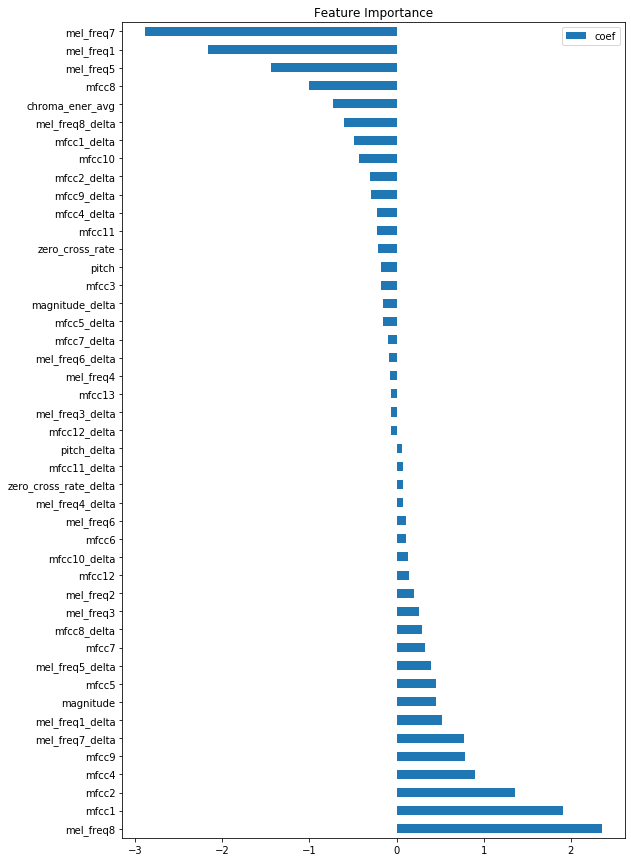

Percent number of features selected: 90.0 %

 ['mel_freq8', 'mfcc1', 'mfcc2', 'mfcc4', 'mfcc9', 'mel_freq7_delta', 'mel_freq1_delta', 'magnitude', 'mfcc5', 'mel_freq5_delta', 'mfcc7', 'mfcc8_delta', 'mel_freq3', 'mel_freq2', 'mfcc12', 'mfcc10_delta', 'mfcc6', 'mel_freq6', 'mel_freq4_delta', 'zero_cross_rate_delta', 'mfcc11_delta', 'pitch_delta', 'mfcc12_delta', 'mel_freq3_delta', 'mfcc13', 'mel_freq4', 'mel_freq6_delta', 'mfcc7_delta', 'mfcc5_delta', 'magnitude_delta', 'mfcc3', 'pitch', 'zero_cross_rate', 'mfcc11', 'mfcc4_delta', 'mfcc9_delta', 'mfcc2_delta', 'mfcc10', 'mfcc1_delta', 'mel_freq8_delta', 'chroma_ener_avg', 'mfcc8', 'mel_freq5', 'mel_freq1', 'mel_freq7']


In [20]:
# visualize feature importance for feature selection
# specify all feature names
# specify min_importance to set minimum importance of feature, feature with importance higher than min_importance will be selected
# if you want to save the figure, just give it a name, otherwise input None

all_feats = [i for i in df.columns if i not in ["Record Id", "improve_0.5"]]
min_importance=0.02 # domain=(0, 1)

# input classifier can be either cross validation or individual model
selected_feats = coef_importance(all_feats, lr_cv, min_importance, None)

# selected features can be used as input for other classifiers
print("\n", selected_feats)

In [21]:
# get prediction results for individual participant prediction outcome
# specify the average probability theshold to determine how high a probability will be judged as 1, otherwise 0 

avg_proba_threshold = 0.5
pred_results = get_pred_results(df, df_label, lr_pred_proba[:,1], avg_proba_threshold)
pred_results

C:\Users\Alvin\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Alvin\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Record Id,avg_proba,pred_0.5,improve_ratio,improve_0.5
0,1055,0.428827,0,0.222222,0
1,217,0.833546,1,0.588235,1
2,287,0.264530,0,0.315789,0
3,464,0.322534,0,0.125000,0
4,518,0.401111,0,0.300000,0
5,591,0.219814,0,0.375000,0
6,751,0.415175,0,0.812500,1
7,911,0.602279,1,0.666667,1
8,924,0.475976,0,0.666667,1
9,942,0.645610,1,0.800000,1


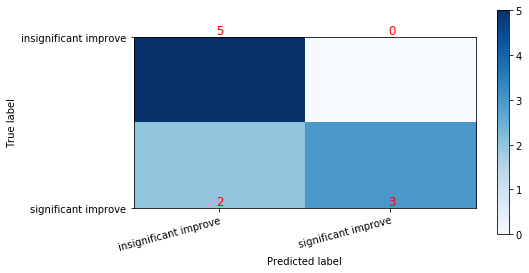

In [31]:
# get individual level confusion matrix using pred_results
# if you want to save the figure, just give it a name, otherwise input None

plot_confusion_matrix(pred_results["improve_0.5"], pred_results["pred_0.5"], None, None)

In [23]:
# get individual level performance metrics

accuracy = (5+3)/10
precision = 3/(3+0)
recall = 3/(3+2)
f1 = 2*precision*recall/(precision+recall)

all_metrics = pd.DataFrame({'Metrics': ['Accuracy','Precision','Recall','f1-score'],
                            'Scores': [accuracy, precision, recall, f1]}).set_index('Metrics')
print(all_metrics)

           Scores
Metrics          
Accuracy     0.80
Precision    1.00
Recall       0.60
f1-score     0.75
